In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import emcee
import pandas as pd
from tqdm import tqdm

In [2]:
from glcat_lightcurve_utils import counts2mag

In [3]:
# from `emcee` documentation:
# Some builds of NumPy (including the version included with Anaconda) will automatically parallelize 
#  some operations using something like the MKL linear algebra. This can cause problems when used with 
#  the parallelization methods described here so it can be good to turn that off (by setting the environment 
#  variable OMP_NUM_THREADS=1, for example).
import os
os.environ["OMP_NUM_THREADS"] = "1"
from multiprocessing import Pool

In [4]:
ncat = pd.read_csv('ncat_240616.csv',index_col=None)

In [5]:
def gaussian_flux_model(theta, r):
    total_flux, sigma, background = theta
    #total_flux, background = theta
    return total_flux * (1 - np.exp(-r**2 / (2 * sigma**2))) + background * np.pi * r**2

def log_likelihood(theta, r, flux, flux_err):
    model = gaussian_flux_model(theta, r)
    return -0.5 * np.sum(((flux - model) / flux_err)**2)

def log_prior(theta):
    total_flux, sigma, background = theta
    if (0 < total_flux < 1000) and (0 < sigma) and (0 < background < 100):
        return 0.0
    return -np.inf
    
def log_probability(theta, r, flux, flux_err):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, r, flux, flux_err)

In [19]:
def fit_aperture_curve(aperture_radii,flux,flux_err,
                       showplots=False, # show the walker plots
                       showstats=False, # print summary results
                       nsteps = 5000, # number of MCMC steps
                       burnin = 200, # number of MCMC steps to burn-in
                      ):
    # Set up the MCMC sampler
    ndim = 3  # Number of parameters to fit (total_flux, sigma, background)
    nwalkers = 32  # Number of MCMC walkers
    
    # Initialize the walkers
    initial_guess = [np.mean(flux), 5/2.355, (flux[-1]-flux[-2])/(np.pi * (aperture_radii[-1]**2-aperture_radii[-2]**2))]
    pos = initial_guess + 1e-4 * np.random.randn(nwalkers, ndim)
    
    # Run the MCMC sampler
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability, args=(aperture_radii, flux, flux_err))
    burn_in = sampler.run_mcmc(pos, burnin)
    sampler.reset()
    sampler.run_mcmc(burn_in, nsteps)
    # sampler.run_mcmc(pos, nsteps)

    if showplots:
        # Plot the MCMC results
        fig, axes = plt.subplots(ndim, figsize=(10, 7), sharex=True)
        samples = sampler.get_chain()
        labels = ["Total Flux", "Sigma", "Background"]
        for i in range(ndim):
            ax = axes[i]
            ax.plot(samples[:, :, i], "k", alpha=0.3)
            ax.set_xlim(0, len(samples))
            ax.set_ylabel(labels[i])
            ax.yaxis.set_label_coords(-0.1, 0.5)
        axes[-1].set_xlabel("Step number")
        plt.tight_layout()
        plt.show()

    # Print the best-fit parameters
    flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
    if showstats:
        print("Best-fit parameters:")
        for i in range(ndim):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            print(f"{labels[i]}: {mcmc[1]:.3f} +{q[1]:.3f} -{q[0]:.3f}")
    return flat_samples

In [20]:
aperture_radii = np.array([1.5, 2.3, 3.8, 6.0, 9.0, 12.8, 17.3])
i = 2078
flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
ix = np.where(np.isfinite(flux))
print(flux,flux_err,ix)

[0.02368422 0.05069129 0.11346207 0.22175821 0.44576024        inf
        inf] [0.00397329 0.00581283 0.00869654 0.01215797 0.01723741        inf
        inf] (array([0, 1, 2, 3, 4]),)


In [21]:
%time flat_samples = fit_aperture_curve(aperture_radii[ix],flux[ix],flux_err[ix],nsteps=500)#,showplots=True)

CPU times: user 735 ms, sys: 2.34 ms, total: 737 ms
Wall time: 736 ms


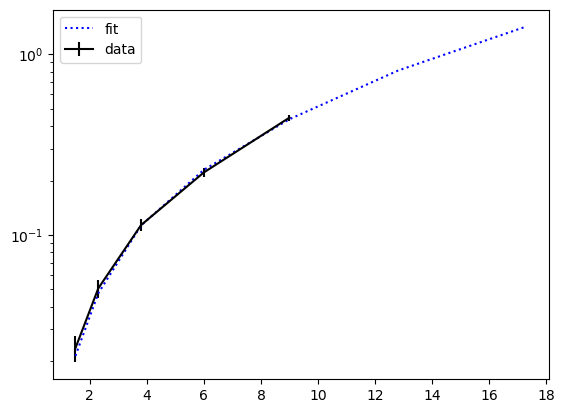

In [60]:
plt.figure()
plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',label='data')
plt.plot(aperture_radii,
         gaussian_flux_model([np.percentile(flat_samples[:, 0], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 1], [16, 50, 84])[1],
                              np.percentile(flat_samples[:, 2], [16, 50, 84])[1],], aperture_radii),'b:',label='fit')
plt.legend()
plt.semilogy();

In [64]:
np.random.seed(420)
models = pd.DataFrame({})
#for i in np.arange(len(ncat)):
for i in tqdm(np.random.randint(0,len(ncat),500)):
    flux = np.array([ncat[f'NUV_CPS_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
    flux_err = np.array([ncat[f'NUV_CPS_ERR_APER{a}'].iloc[i] for a,r in enumerate(aperture_radii)])
    flat_samples = fit_aperture_curve(aperture_radii,flux,flux_err,nsteps=200,showplots=False)
    a,b,c = (np.percentile(flat_samples[:, 0], [16, 50, 84])[1],
             np.percentile(flat_samples[:, 1], [16, 50, 84])[1],
             np.percentile(flat_samples[:, 2], [16, 50, 84])[1])
    
    models = pd.concat([models,
                        pd.DataFrame({'cps':[a],
                                      'sigma':[b],
                                      'bg':[c],
                                      'bg_aper':[(flux[-1]-flux[-2])/(np.pi * (aperture_radii[-1]**2 - aperture_radii[-2]**2))],
                                      })],
                       axis=0)

    # plt.figure()
    # plt.errorbar(aperture_radii,flux,yerr=flux_err,fmt='k-',label='data')
    # plt.plot(aperture_radii,
    #         gaussian_flux_model([a,b,c,], aperture_radii),'b:',
    #          label=f'flux,sigma,bg= ({a:.3f} {b:.3f} {c:.3f})')
    # plt.legend()
    # plt.semilogy();

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [03:16<00:00,  2.55it/s]


In [65]:
models = models.reset_index(drop=True)
models.keys()

Index(['cps', 'sigma', 'bg', 'bg_aper'], dtype='object')

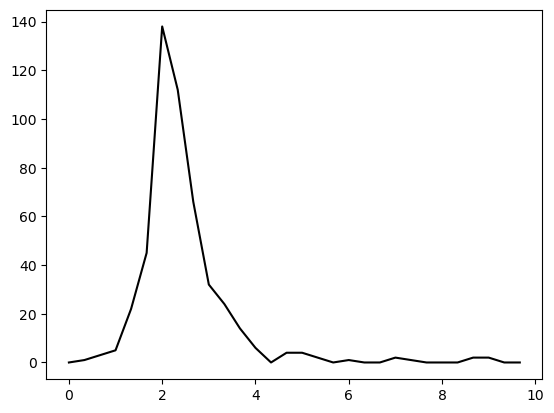

In [66]:
bins,vals = np.histogram(models['sigma'],bins=30,range=[0,10])
plt.plot(vals[:-1],bins,'k-')

(0.001, 0.005)

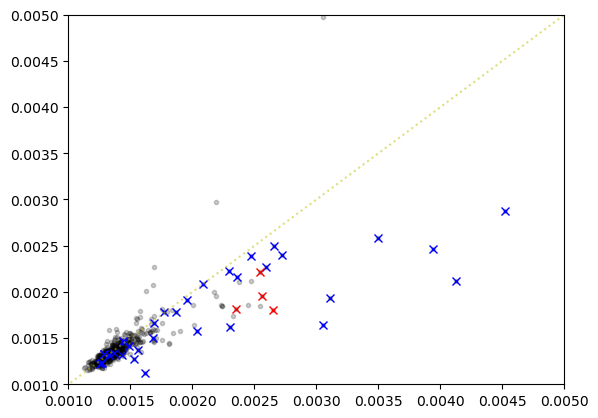

In [79]:
bix = np.where(models['sigma']>4)
rix = np.where(models['sigma']<1)
plt.plot(models['bg_aper'],models['bg'],'k.',alpha=0.2)
plt.plot(models['bg_aper'].values[bix],models['bg'].values[bix],'bx',alpha=1)
plt.plot(models['bg_aper'].values[rix],models['bg'].values[rix],'rx',alpha=1)
plt.plot([0,500],[0,500],'y:',alpha=0.5)
plt.xlim([0.001,0.005])
plt.ylim([0.001,0.005])
#plt.loglog()

[]

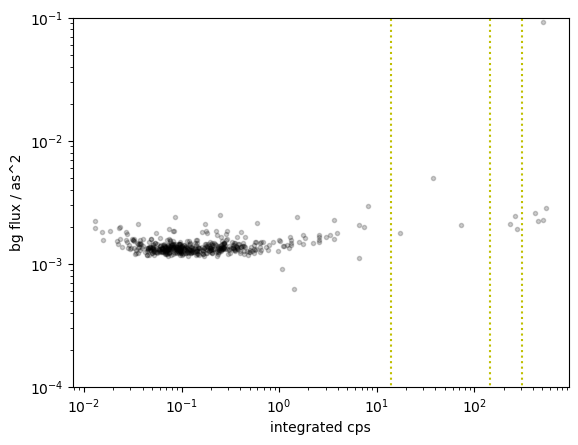

In [95]:
plt.plot(models['cps'],models['bg'],'k.',alpha=0.2)
plt.xlabel('integrated cps')
plt.ylabel('bg flux / as^2')
plt.vlines([14.1,145,311],0,100,colors='y',linestyles='dotted')
plt.ylim([10**-4,10**-1])
plt.loglog()

In [83]:
? plt.vlines

Signature:
 plt.vlines(
    x: 'float | ArrayLike',
    ymin: 'float | ArrayLike',
    ymax: 'float | ArrayLike',
    colors: 'ColorType | Sequence[ColorType] | None' = None,
    linestyles: 'LineStyleType' = 'solid',
    label: 'str' = '',
    *,
    data=None,
    **kwargs,
) -> 'LineCollection'
Docstring:
Plot vertical lines at each *x* from *ymin* to *ymax*.

Parameters
----------
x : float or array-like
    x-indexes where to plot the lines.

ymin, ymax : float or array-like
    Respective beginning and end of each line. If scalars are
    provided, all lines will have the same length.

colors : color or list of colors, default: :rc:`lines.color`

linestyles : {'solid', 'dashed', 'dashdot', 'dotted'}, default: 'solid'

label : str, default: ''

Returns
-------
`~matplotlib.collections.LineCollection`

Other Parameters
----------------
data : indexable object, optional
    If given, the following parameters also accept a string ``s``, which is
    interpreted as ``data[s]`` (unless